## **3. Pondération statistique** (TF-IDF / OKapiBM25)  

https://stackoverflow.com/questions/46580932/calculate-tf-idf-using-sklearn-for-n-grams-in-python  
http://scikit-learn.sourceforge.net/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn-feature-extraction-text-tfidfvectorizer  
https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

https://pypi.org/project/rank-bm25/

In [1]:
path = '../04-filtrage/output/'
acteur = 'ciusss_coi'
tag = ''

if tag:
    csv_file = acteur + '_' + tag + '_significant-collocations.csv'

else:
    csv_file = acteur + '_significant-collocations.csv'

### **Lire le vocabulaire** (termes retenus au prétraitement)

In [2]:
from pandas import *

with open(path+csv_file, encoding='utf-8') as f:
    csv = read_csv(f)[["Collocation", "Structure syntaxique", "Fréquence", "LLR", "p-value"]]

csv

,Collocation,Structure syntaxique,Fréquence,LLR,p-value
0,santé info social,NOM ADJ ADJ,1318,-inf,1.000000e+00
1,santé info,NOM ADJ,1318,-inf,1.000000e+00
2,innovation orot,NOM ADJ,1300,-inf,1.000000e+00
3,innovation orot leadership,NOM ADJ NOM,745,-inf,1.000000e+00
4,lutte contre la maltraitance,NOM PRP DET:ART NOM,586,-inf,1.000000e+00
...,...,...,...,...,...
1572,membres du personnel du ciusss,NOM PRP:det NOM PRP:det NOM,6,53.318270,2.836561e-13
1573,older long term care residents,NOM ADJ NOM ADJ ADJ,6,131.194141,2.245368e-30
1574,programme fédéral de santé,NOM ADJ PRP NOM,6,45.563191,1.477930e-11
1575,représentant désigné,NOM VER:pper,6,107.243763,3.936475e-25


In [3]:
vocabulaire = [t.lower() for t in list(csv['Collocation'])]

In [4]:
print('On a un vocabulaire de {} formes.'.format(len(vocabulaire)))
vocabulaire

On a un vocabulaire de 1577 formes.


['santé info social',
 'santé info',
 'innovation orot',
 'innovation orot leadership',
 'lutte contre la maltraitance',
 'rôle le mandat',
 'innovation orot leadership politiques',
 'nom courriel commentaire',
 'champ ciusss du centre',
 'champ ciusss',
 'champ ciusss du centre ouest',
 'services sociaux',
 'services intégrés',
 "guichet d'accès",
 'côte des neiges',
 'directeur général',
 'santé 811',
 'autonomie des personnes âgées',
 'father dowd',
 'henri bradet',
 'chsld juif',
 'centre miriam',
 'chsld juif donald berman',
 'santé mentale adulte',
 'prévention cardiovasculaire',
 'prévention des chutes',
 'programme de santé',
 'programme de santé mentale',
 'jeunes en difficulté',
 'abandon du tabagisme',
 'portrait de la population',
 'services intégrés de dépistage',
 'visites ministérielles',
 'benny farm',
 'clsc de benny',
 'clsc de benny farm',
 'hôpital catherine booth',
 'clsc rené',
 'clsc rené cassin',
 'centre gériatrique',
 'développement durable',
 'centre gériatri

### **Lire le corpus**

In [5]:
import os, shutil, re
from pathlib import Path
from os import path
from pandas import *

base_path = '../03-corpus/2-data/1-fr/'
if tag:
    base_path = path.join(base_path, acteur, acteur + '_' + tag + '.csv')

else:
    base_path = path.join(base_path, acteur +  '.csv')
        
with open(base_path, "r", encoding = "UTF-8") as f:
    data = read_csv(base_path)
    text = data['text'].tolist()

corpus = [t.strip('\n').lower().replace('’', '\'').replace("œ", "oe") for t in data]
    
punct = '[!#$%&\(\)*+,-/:;<=>?@[\]^_{|}~©«»—“”–—]'
spaces = '\s+'

corpus = [re.sub(punct, ' ', t).replace("' ", "'" ).replace("'", "'") for t in text]
corpus = [re.sub(spaces, ' ', t) for t in corpus]

In [6]:
corpus = corpus[:round(len(corpus))]

nb_docs = len(corpus)

print("On a donc un corpus de {} documents.".format(nb_docs))

On a donc un corpus de 559 documents.


### **Appliquer le prétraitement**
Si les termes passées comme vocabulaire sont lemmatisés, changer le paramètre lem pour True au moment d'appliquer la fonction nlp(corpus)  
Le TfIdfVectorizer de sklearn va extraire lui-mêmes les ngrammes, faire le filtrage des mots fonctionnels et calculer le tf-idf pour nos termes d'intérêt ;  
Or, si les termes qu'on lui donne comme vocabulaire ont été lemmatisés, on veut donc aussi lui passer un corpus lemmatisé.

In [7]:
import nltk
from nltk.tokenize import RegexpTokenizer
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

def nlp(corpus, lem=False): 
    if not lem:
        # Tokenisation
        tokenizer = RegexpTokenizer(r"\w\'|\w+")

        tokens = [tokenizer.tokenize(doc) for  doc in corpus]
        len_corpus = len(nltk.flatten(tokens))
        print("Avec le RegExpTokenizer, notre corpus contient {} tokens.".format(len_corpus))

        return tokens

    else:
        # POS tagging
        input = [" ".join(nltk.flatten(doc)).replace("' ", "'") for doc in tokens]
        import treetaggerwrapper
        tagger = treetaggerwrapper.TreeTagger(TAGLANG='fr')

        path = '../04-filtrage/mapping_treeTagger_lefff.csv'

        with open(path) as f:
            csv = read_csv(f)

        treeTag = [term for term in csv['TreeTagger'].tolist()] 
        lefff = [term for term in csv['Lefff'].tolist()]

        mapping = {term : lefff[treeTag.index(term)] for term in treeTag}

        tagged= [tagger.tag_text(doc) for doc in input]

        tuples_doc = []
        for doc in tagged:
            tuples = []
            for t in doc:
                token = t.split('\t')[0]
                pos = mapping[t.split('\t')[1]]

                tuples.append([token, pos])
            tuples_doc.append(tuples)

        #Lemmatisation
        lemmatizer = FrenchLefffLemmatizer()
        docs_lemmas = []

        for doc in tuples_doc:
            doc_lemma = []
            for t in doc:
                term_lemmatized = ""
                if(lemmatizer.lemmatize(t[0], t[1]) == []):
                    term_lemmatized = lemmatizer.lemmatize(t[0])
                else:
                    term_lemmatized = lemmatizer.lemmatize(t[0], t[1])[0][0] # [0][0] pour avoir le lemme seul et non (lemme, pos)
            
                if len(term_lemmatized) >1 :
                    doc_lemma.append(term_lemmatized)
            docs_lemmas.append(doc_lemma)

        docs_lemmas = [" ".join(doc) for doc in docs_lemmas]

        return docs_lemmas

In [8]:
corpus = nlp(corpus)

Avec le RegExpTokenizer, notre corpus contient 633541 tokens.


In [9]:
file_path = '../04-filtrage/mwe_stopwords.txt'

with open (file_path, 'r', encoding='utf-8') as f:
    mwe_sw = [t.lower().strip('\n') for t in f.readlines()]

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# max_df : ignore words that appear in 85% of documents, 
# min df:  ignore words that appear in less than 1% of documents 
# vocabulary = vocabulaire

# Sans utiliser le vocabulaire
# tfidf = TfidfVectorizer(min_df=0.1, stop_words=None, ngram_range=(2,4), max_df=0.85, use_idf=True)

def identity_tokenizer(text):
    return text

# vocabulary = vocabulaire
tfidf = TfidfVectorizer(vocabulary = vocabulaire, tokenizer=identity_tokenizer, ngram_range=(2,5), use_idf=True, lowercase=False, stop_words= mwe_sw)
tfs = tfidf.fit_transform(corpus)

c:\Users\p1115145\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [' ', "'", '-', '0', '1', '2', '3', '4', '5', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ñ', 'œ', '’'] not in stop_words.
  warnings.warn(


In [11]:
features_names = tfidf.get_feature_names_out()
corpus_index = [corpus.index(n) for n in corpus]

import pandas as pd
df = pd.DataFrame(tfs.T.todense(), index=features_names, columns=corpus_index).transpose()

In [12]:
df

,santé info social,santé info,innovation orot,innovation orot leadership,lutte contre la maltraitance,rôle le mandat,innovation orot leadership politiques,nom courriel commentaire,champ ciusss du centre,champ ciusss,...,résidents du centre,centres de jour,service régional info,carnet de vaccination,centre sud,membres du personnel du ciusss,older long term care residents,programme fédéral de santé,représentant désigné,maladies cardiovasculaires
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.0,0.0,0.0,0.0,0.086408,0.129940,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
237,0.0,0.0,0.0,0.0,0.154056,0.231668,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
234,0.0,0.0,0.0,0.0,0.108057,0.162495,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251,0.0,0.0,0.0,0.0,0.201434,0.302916,0.0,0.0,0.0,0.0,...,0.0,0.268631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# from pathlib import Path

# base_path = '../05-transformation/' + acteur + '/'
# Path(base_path).mkdir(parents=True, exist_ok=True)

# if sous_corpus:
#     path = base_path + tag + '/'
#     titre = tag

# else:
#     titre = acteur

# df.to_csv(base_path + titre + '_matrice-TFIDF.csv')

In [14]:
terms_weighted = []
rows, cols = tfs.nonzero()
for row, col in zip(rows,cols):
    terms_weighted.append([features_names[col], tfs[row,col]])

terms_weighted = DataFrame(terms_weighted, columns=['Collocation', 'TF-IDF'])
terms_weighted.sort_values(["TF-IDF"], 
                    axis=0,
                    ascending=[False], 
                    inplace=True)

In [15]:
terms_weighted = terms_weighted.drop_duplicates(keep='first')

In [16]:
terms_weighted = pd.merge(csv, terms_weighted, on='Collocation').drop_duplicates(
  subset = ['Collocation', 'Fréquence'],
  keep = 'first').reset_index(drop = True)

In [17]:
terms_weighted.to_csv('C:/Users/p1115145/Documents/text-mining-project/05-transformation/msss/' + 'cancer-TEST' + '_weighting_TF-IDF.csv')

**Test : clustering (documents)**

In [33]:
def cluster_text(corpus):
    # vocabulary = vocabulaire
    vectorizer = TfidfVectorizer(vocabulary = vocabulaire, tokenizer=identity_tokenizer, ngram_range=(2,5), use_idf=True, lowercase=False, stop_words= mwe_sw)
    X = vectorizer.fit_transform(corpus)

    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    Sum_of_squared_distances = []
    K = range(2,10)
    for k in K:
       km = KMeans(n_clusters=k, max_iter=200, n_init=10)
       km = km.fit(X)
       Sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

    print('How many clusters do you want to use?')
    true_k = int(input())
    model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
    model.fit(X)

    labels=model.labels_
    clusters=pd.DataFrame(list(zip(text,labels)),columns=['title','cluster'])
    #print(clusters.sort_values(by=['cluster']))

    for i in range(true_k):
        print(clusters[clusters['cluster'] == i])
        clusters.to_csv('../06-clustering/' + acteur + '_clusters.csv')
        
    return

c:\Users\p1115145\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [' ', "'", '-', '0', '1', '2', '3', '4', '5', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ñ', 'œ', '’'] not in stop_words.
  warnings.warn(


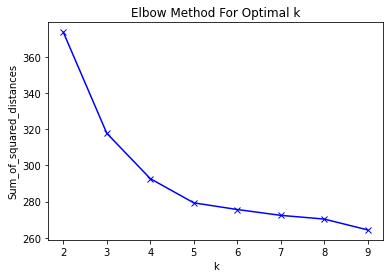

How many clusters do you want to use?
                                                 title  cluster
30   CIUSSS du Centre-Ouest-de-l’Île-de-Montréal | ...        0
31   CIUSSS du Centre-Ouest-de-l’Île-de-Montréal | ...        0
32   CIUSSS du Centre-Ouest-de-l’Île-de-Montréal | ...        0
33   CIUSSS du Centre-Ouest-de-l’Île-de-Montréal | ...        0
34   CIUSSS du Centre-Ouest-de-l’Île-de-Montréal | ...        0
..                                                 ...      ...
507  CIUSSS du Centre-Ouest-de-l’Île-de-Montréal | ...        0
549  CIUSSS du Centre-Ouest-de-l’Île-de-Montréal | ...        0
555  CIUSSS du Centre-Ouest-de-l’Île-de-Montréal | ...        0
557  CIUSSS du Centre-Ouest-de-l’Île-de-Montréal | ...        0
558  CIUSSS du Centre-Ouest-de-l’Île-de-Montréal | ...        0

[168 rows x 2 columns]
                                                 title  cluster
1    CIUSSS du Centre-Ouest-de-l’Île-de-Montréal | ...        1
2    CIUSSS du Centre-Ouest-de-l’Île-de-Mo

In [34]:
cluster_text(corpus)

## **OKapi BM25**
https://hal.archives-ouvertes.fr/hal-00760158 

In [18]:
from rank_bm25 import BM25Okapi

In [19]:
bm25 = BM25Okapi(corpus)

In [20]:
tokenizer = RegexpTokenizer(r"\w\'|\w+")
tokenized_queries = [tokenizer.tokenize(t) for t in vocabulaire]

features_names = [t for t in vocabulaire]
corpus_index = [corpus.index(n) for n in corpus]

tab = [bm25.get_scores(query) for query in tokenized_queries]
df = pd.DataFrame(tab, index=features_names, columns=corpus_index).transpose()

In [21]:
# df.to_csv(base_path + titre + '_matrice-OkapiBM25.csv') # Si on veut avoir la matrice (mais le fichier peut être très volumineux)

In [22]:
terms_okapi = {term: df[term].max() for term in df}

In [23]:
tab = DataFrame(terms_okapi.items(), columns=['Collocation', 'OkapiBM25'])
tab.sort_values(["OkapiBM25"], 
                    axis=0,
                    ascending=[False], 
                    inplace=True)

tab = pd.merge(terms_weighted, tab, on="Collocation")

In [24]:
base_path = '../05-transformation/'

In [25]:
if tag:
    file_path = base_path + acteur + '_' + tag + '_weighting_OKapiBM25.csv'

else: 
    file_path = base_path + acteur  + '_weighting_OKapiBM25.csv'
tab.to_csv(file_path)

In [26]:
tab

,Collocation,Structure syntaxique,Fréquence,LLR,p-value,TF-IDF,OkapiBM25
0,lutte contre la maltraitance,NOM PRP DET:ART NOM,586,-inf,1.000000e+00,0.662732,6.191492
1,rôle le mandat,NOM DET:ART NOM,582,-inf,1.000000e+00,0.685042,4.920488
2,services sociaux,NOM ADJ,539,-inf,1.000000e+00,1.000000,5.725323
3,services intégrés,NOM VER:pper,538,-inf,1.000000e+00,0.329341,5.145369
4,directeur général,NOM ADJ,414,-inf,1.000000e+00,0.609216,8.565782
...,...,...,...,...,...,...,...
569,centres de jour,NOM PRP NOM,6,16.995365,3.747118e-05,0.268631,10.227313
570,carnet de vaccination,NOM PRP NOM,6,69.560908,7.409090e-17,0.781156,15.249515
571,older long term care residents,NOM ADJ NOM ADJ ADJ,6,131.194141,2.245368e-30,0.022963,39.917375
572,représentant désigné,NOM VER:pper,6,107.243763,3.936475e-25,0.637327,14.326234
